In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import StructType, StructField, ArrayType, DoubleType, IntegerType
from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler
import numpy as np
import random

class CURE:
    def __init__(self, k, num_representatives=10, shrinking_factor=0.3, sample_size=None, num_partitions=10, outlier_threshold=2):
        self.k = k
        self.num_representatives = num_representatives
        self.shrinking_factor = shrinking_factor
        self.sample_size = sample_size
        self.num_partitions = num_partitions
        self.outlier_threshold = outlier_threshold
        self.spark = SparkSession.builder.appName("CURE").getOrCreate()

    def fit(self, data):
        # Step 1: Random Sampling
        if self.sample_size:
            sampled_data = data.sample(False, self.sample_size / data.count())
        else:
            sampled_data = data

        # Step 2: Partitioning
        partitioned_data = sampled_data.repartition(self.num_partitions)

        # Step 3: Partial clustering on each partition
        partial_clusters = self._partial_clustering(partitioned_data)

        # Step 4: Final clustering of partial clusters
        final_clusters = self._final_clustering(partial_clusters)

        # Step 5: Get representatives
        self.representatives = self._get_representatives(final_clusters)

        return self

    def predict(self, data):
        # Broadcast representatives to all nodes
        bc_representatives = self.spark.sparkContext.broadcast(self.representatives)

        # Define UDF for finding nearest cluster
        @udf(IntegerType())
        def assign_cluster(point):
            representatives = bc_representatives.value
            return CURE._find_nearest_cluster(point, representatives)

        return data.withColumn("cluster", assign_cluster("features"))

    def _partial_clustering(self, partitioned_data):
        k = self.k
        num_representatives = self.num_representatives
        shrinking_factor = self.shrinking_factor
        outlier_threshold = self.outlier_threshold

        return partitioned_data.rdd.mapPartitions(
            lambda iterator: CURE._cluster_partition(iterator, k, num_representatives, shrinking_factor, outlier_threshold)
        ).collect()

    def _final_clustering(self, partial_clusters):
        while len(partial_clusters) > self.k:
            i, j = self._find_closest_partial_clusters(partial_clusters)
            merged = self._merge_partial_clusters(partial_clusters[i], partial_clusters[j])
            partial_clusters[i] = merged
            partial_clusters.pop(j)
        return partial_clusters

    def _find_closest_partial_clusters(self, partial_clusters):
        min_dist = float('inf')
        min_pair = (0, 0)

        for i in range(len(partial_clusters)):
            for j in range(i + 1, len(partial_clusters)):
                dist = CURE._partial_cluster_distance(partial_clusters[i], partial_clusters[j])
                if dist < min_dist:
                    min_dist = dist
                    min_pair = (i, j)

        return min_pair

    def _merge_partial_clusters(self, cluster1, cluster2):
        total_size = cluster1['size'] + cluster2['size']
        new_center = (cluster1['center'] * cluster1['size'] + cluster2['center'] * cluster2['size']) / total_size
        new_scattered = CURE._select_scattered_points(cluster1['scattered_points'] + cluster2['scattered_points'], self.num_representatives)
        return {
            'center': new_center,
            'size': total_size,
            'scattered_points': new_scattered
        }

    def _get_representatives(self, clusters):
        representatives = []
        for cluster in clusters:
            representatives.append(cluster['scattered_points'])
        return representatives

    @staticmethod
    def _cluster_partition(iterator, k, num_representatives, shrinking_factor, outlier_threshold):
        partition_points = list(iterator)
        if len(partition_points) == 0:
            return iter([])

        clusters = [[p.features.toArray()] for p in partition_points]
        while len(clusters) > max(k, len(partition_points) // 3):  # Stop at k or 1/3 of partition size
            i, j = CURE._find_closest_clusters(clusters)
            clusters[i] = clusters[i] + clusters[j]
            clusters.pop(j)

        return iter([CURE._get_cluster_summary(cluster, num_representatives, shrinking_factor, outlier_threshold) for cluster in clusters])

    @staticmethod
    def _get_cluster_summary(cluster, num_representatives, shrinking_factor, outlier_threshold):
        center = np.mean(cluster, axis=0)
        distances = [np.linalg.norm(np.array(p) - center) for p in cluster]
        mean_distance = np.mean(distances)
        std_distance = np.std(distances)

        # Eliminate outliers based on distance from center
        filtered_cluster = [p for p, d in zip(cluster, distances) if d <= mean_distance + outlier_threshold * std_distance]

        scattered_points = CURE._select_scattered_points(filtered_cluster, num_representatives)
        shrunk_points = [center + shrinking_factor * (p - center) for p in scattered_points]
        return {
            'center': center,
            'size': len(filtered_cluster),
            'scattered_points': shrunk_points
        }

    @staticmethod
    def _select_scattered_points(cluster, num_representatives):
        if len(cluster) <= num_representatives:
            return cluster

        scattered = [np.array(random.choice(cluster))]
        while len(scattered) < num_representatives:
            max_min_dist = -1
            max_point = None
            for point in cluster:
                point = np.array(point)
                min_dist = min(np.linalg.norm(point - s) for s in scattered)
                if min_dist > max_min_dist:
                    max_min_dist = min_dist
                    max_point = point
            scattered.append(max_point)
        return scattered

    @staticmethod
    def _find_closest_clusters(clusters):
        min_dist = float('inf')
        min_pair = (0, 0)

        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                dist = CURE._cluster_distance(clusters[i], clusters[j])
                if dist < min_dist:
                    min_dist = dist
                    min_pair = (i, j)

        return min_pair

    @staticmethod
    def _cluster_distance(cluster1, cluster2):
        return min(np.linalg.norm(np.array(p1) - np.array(p2)) for p1 in cluster1 for p2 in cluster2)

    @staticmethod
    def _partial_cluster_distance(cluster1, cluster2):
        return min(np.linalg.norm(np.array(p1) - np.array(p2))
                   for p1 in cluster1['scattered_points']
                   for p2 in cluster2['scattered_points'])

    @staticmethod
    def _find_nearest_cluster(point, representatives):
        min_dist = float('inf')
        nearest_cluster = -1
        point_array = np.array(point.toArray())
        for i, cluster_reps in enumerate(representatives):
            dist = min(np.linalg.norm(point_array - np.array(rep)) for rep in cluster_reps)
            if dist < min_dist:
                min_dist = dist
                nearest_cluster = i
        return nearest_cluster

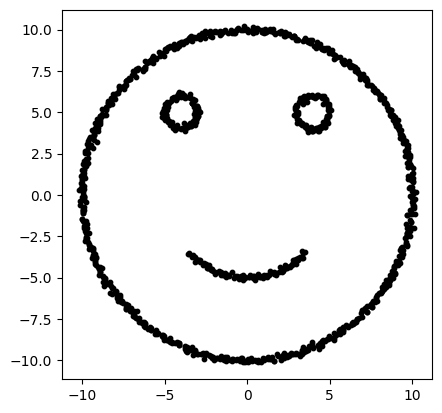

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate circle points with random perturbation
def generate_circle_points(center, radius, num_points, noise_level=0.1):
    angles = np.linspace(0, 2 * np.pi, num_points)
    x = center[0] + radius * np.cos(angles) + np.random.normal(0, noise_level, num_points)
    y = center[1] + radius * np.sin(angles) + np.random.normal(0, noise_level, num_points)
    return x, y

# Generate points for the face outline
face_center = (0, 0)
face_radius = 10
num_face_points = 800
face_x, face_y = generate_circle_points(face_center, face_radius, num_face_points)

# Generate points for the left eye
left_eye_center = (-4, 5)
left_eye_radius = 1
num_eye_points = 100
left_eye_x, left_eye_y = generate_circle_points(left_eye_center, left_eye_radius, num_eye_points)

# Generate points for the right eye
right_eye_center = (4, 5)
right_eye_radius = 1
right_eye_x, right_eye_y = generate_circle_points(right_eye_center, right_eye_radius, num_eye_points)

# Generate points for the mouth
def generate_mouth_points(center, radius, num_points, noise_level=0.1):
    angles = np.linspace(-np.pi / 4, -3 * np.pi / 4, num_points)
    x = center[0] + radius * np.cos(angles) + np.random.normal(0, noise_level, num_points)
    y = center[1] + radius * np.sin(angles) + np.random.normal(0, noise_level, num_points)
    return x, y

mouth_center = (0, 0)
mouth_radius = 5
num_mouth_points = 100
mouth_x, mouth_y = generate_mouth_points(mouth_center, mouth_radius, num_mouth_points)

# Combine all points
x = np.concatenate([face_x, left_eye_x, right_eye_x, mouth_x])
y = np.concatenate([face_y, left_eye_y, right_eye_y, mouth_y])

# Plot the points
plt.scatter(x, y, s=10, c='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Save points to a file
data = np.column_stack((x, y))
np.savetxt('./smiley_face_random_points.csv', data, delimiter=',', header='x,y', comments='')

In [6]:
# Visualize clustering result
def visualize_clusters(data, labels, title):
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    plt.close()

+--------------------+-------+
|            features|cluster|
+--------------------+-------+
|[10.0596354785972...|      0|
|[10.1957123431364...|      0|
|[10.0064787831179...|      0|
|[10.0935993202670...|      0|
|[10.0534230378868...|      0|
|[9.86214384859492...|      0|
|[9.95898737338723...|      0|
|[9.82194475181663...|      0|
|[10.0344142379671...|      0|
|[9.91258410489240...|      0|
|[9.99877347919480...|      0|
|[10.0522467622363...|      0|
|[9.75873457887289...|      0|
|[10.0230430122875...|      0|
|[9.90242160258041...|      0|
|[9.99570279384104...|      0|
|[9.98892420752750...|      0|
|[9.74749338663750...|      0|
|[10.0320582327772...|      0|
|[10.0104230210830...|      0|
+--------------------+-------+
only showing top 20 rows



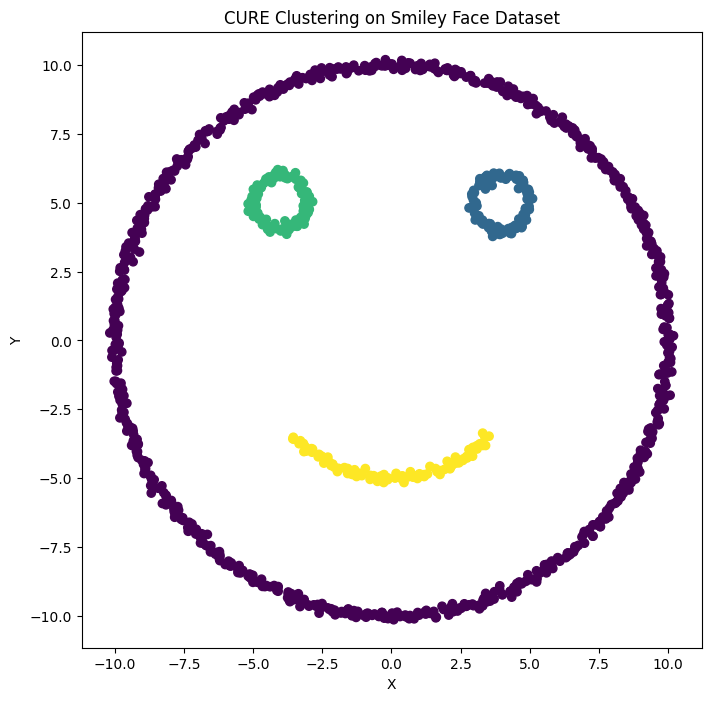

In [7]:
# Usage example:

if __name__ == "__main__":
    spark = SparkSession.builder.appName("CURE_Example").getOrCreate()

    # Create smiley face synthetic dataset
    data = spark.read.csv('./smiley_face_random_points.csv', header=True, inferSchema=True)
    assembler = VectorAssembler(
        inputCols=["x", "y"],
        outputCol="features"
    )

    data = assembler.transform(data).select("features")

    # Initialize and fit CURE
    cure = CURE(k=4, num_representatives=25, shrinking_factor=0.4, sample_size=None, num_partitions=10, outlier_threshold = 3)
    cure.fit(data)

    # Predict clusters
    result = cure.predict(data)
    result.show()

    # Collect and visualize results
    cluster_result = result.select("features", "cluster").collect()
    features = np.array([row['features'] for row in cluster_result])
    labels = np.array([row['cluster'] for row in cluster_result])

    visualize_clusters(features, labels, "CURE Clustering on Smiley Face Dataset")

    spark.stop()